## The Quantum Approximate Optimisation Algorithm (QAOA) using TKET, optimizing Compilation Time

## The Max-Cut problem

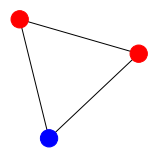

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,0)])
plt.figure(figsize=(2,2))
nx.draw(G, node_color=['red', 'blue', 'red'])
plt.show()

There are \\(2^3\\) possible assignments of colour to nodes. In general there are \\( 2^n \\). The Max-cut problem can then be stated as that of finding the colour assignment which maximises the number of edges between vertices of a different colour.

## Quantum Approximate Optimization Algorithm (QAOA)

Introduced in 'A Quantum Approximate Optimization Algorithm' (found at https://arxiv.org/abs/1411.4028). The idea is to prepare a quantum state which encodes a solution to the Max-cut problem.


This is a variational algorithm, which is to say that a paramaterised state is prepared, with the parameters varied to improve the solution. We will have $2p$ parameters where p is our number of layers. In particular, the state prepared has the form 



\\[ \left| \psi \left( \beta, \gamma \right) \right\rangle = U \left( \beta_m \right) U \left( \gamma_m \right) ... U \left( \beta_0 \right) U \left( \gamma_0 \right) \left| \psi_0 \right\rangle \\]
where
\\[ U \left( \beta_i \right) = e^{i \beta H_B} \quad \& \quad U \left( \gamma_i \right) = e^{i \gamma H_P} \\]
with \\( H_B \\) and \\( H_P \\) depending on the problem instance. 

## Cost function for Maxcut
$$
\begin{equation}
C= \sum_{(i,j)} x_i(1-x_j)
\end{equation}
$$

For the previous 3 vertex graph the *problem Hamiltonian* is
\\[ H_P = \frac{1}{2} \big[ \left( Z \otimes Z \otimes I \right) + \left( Z \otimes I \otimes Z \right) + \left( I \otimes Z \otimes Z \right) \big] \\]


where you will notice that there is a \\( Z \otimes Z \\) acting between each vertex which is connected by an edge.

The *mixer Hamiltonian* has the form 
\\[ H_B =   \left( X \otimes I \otimes I \right) + \left( I \otimes X \otimes I \right) + \left( I \otimes I \otimes X \right)  \\]


where you will notice that there is an \\( X \\) acting on each vertex.

## Cost function for Maxcut

A solution to maxcut can be found by maximising the following cost function $C$ .



$$
\begin{equation}
C= \sum_{(i,j)} x_i(1-x_j)
\end{equation}
$$

Here $x_i$ and $x_j$ are the the "colours" of each vertex.  

$$
\begin{equation}
x_i,x_j \in \{0,1\}
\end{equation}
$$

$x_i(1-x_j)=0$ if $x_i=x_j$ and $ x_i(1-x_j)=1$ if the terms are not equal.

We want to encode our Maxcut cost function as a Hamiltonain. To do this we can perform the following translation.

$$
\begin{equation}
x_i \mapsto \frac{1}{2}(1-Z_i)
\end{equation}
$$


The Pauli Z operator can be used to distinguish between the $|0\rangle$ and $|1\rangle$ basis states as these are eigenstates with eigenvalues $\pm 1$ .

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{<jk>} (-Z_j \,Z_k +I )
\end{equation}
$$


$$
\begin{equation}
H_B = \sum_i X_i
\end{equation}
$$

Here we use the the convention that $X_i$ means a Pauli X operator will be applied to the "ith" qubit and the identity operator will be applied to all other qubits in the circuit.

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Circuit Construction for QAOA

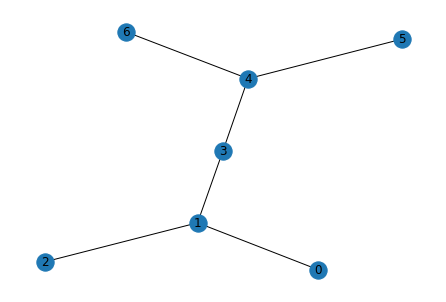

In [3]:
import networkx as nx

max_cut_graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0,1,0,0,1,0,0), (1,0,1,1,0,1,1)]

## Define Cost Hamiltonian: $\gamma H$

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{<jk>} (-Z_j \,Z_k +I )
\end{equation}
$$

In [4]:
from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5*cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, cost_angle)
print(cost_ham_qpo)

{(): 3.00000000000000, (Zq[0], Zq[1]): -0.500000000000000, (Zq[1], Zq[2]): -0.500000000000000, (Zq[1], Zq[3]): -0.500000000000000, (Zq[3], Zq[4]): -0.500000000000000, (Zq[4], Zq[5]): -0.500000000000000, (Zq[4], Zq[6]): -0.500000000000000}


$$
\begin{equation}
H_P = 3 I^{\otimes 6} -0.5 \big[ Z_0 Z_1 + Z_1 Z_2 +Z_1 Z_3 +Z_3 Z_4 +Z_4 Z_5 +Z_4 Z_6  \big]
\end{equation}
$$

Using the same index convention as above

## Hamiltonian Circuit

In [5]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(n_nodes))
display.render_circuit_jupyter(cost_ham_circuit)

In [6]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

## Construction of the Mixer Hamiltonian: $\beta B$

In [7]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(n_nodes)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(n_nodes))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

## Define the Initial State

In [36]:
from pytket.backends.backend import Backend
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(n_nodes)

display.render_circuit_jupyter(superposition_circuit)

Transform.DecomposeBoxes().apply(superposition_circuit)
backend.default_compilation_pass(2).apply(superposition_circuit)

True

## Construct QAOA Circuit

Now lets define a function to create our entire QAOA circuit. For $p$ QAOA layers we expect that our circuit will require $2p$ parameters. Here we will pass and cost mixer parameters in as a list where the length of the list defines the number of layers.

In [45]:
%%time
cost_circuits = []
mixer_circuits = []

for i in range(10):
    cost_circuit = gen_term_sequence_circuit(qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, 1/(2**(i + 1))), Circuit(n_nodes))
    mixer_circuit = gen_term_sequence_circuit(QubitPauliOperator({QubitPauliString([Qubit(j)], [Pauli.X]): 1/(2**(i + 1)) for j in range(n_nodes)}), Circuit(n_nodes))
    Transform.DecomposeBoxes().apply(cost_circuit)
    Transform.DecomposeBoxes().apply(mixer_circuit)
    backend.default_compilation_pass(2).apply(cost_circuit)
    backend.default_compilation_pass(2).apply(mixer_circuit)
    cost_circuits.append(cost_circuit)
    mixer_circuits.append(mixer_circuit)
    

CPU times: user 1.4 s, sys: 1e+03 ns, total: 1.4 s
Wall time: 1.4 s


In [40]:
def qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                         n_nodes: int,
                         mixer_angles: List[int],
                         cost_angles: List[int]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = superposition_circuit.copy()
    
    
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        for i in range(10):
            if (cost & (1 << i)):
                qaoa_circuit.append(cost_circuits[9 - i])
        for i in range(10):
            if (mixer & (1 << i)):
                qaoa_circuit.append(mixer_circuits[9 - i])
        
    print(qaoa_circuit)
                
    return qaoa_circuit

We also need to extract our energy expectation values from a `BackendResult` object after our circuit is processed by the device/simulator. We do this with the `get_max_cut_energy` function below. Note that the fact that the maxcut Hamiltonian contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits. This may not the the case for a different problem Hamiltonian.

In [24]:
from typing import List, Tuple
from pytket.backends.backendresult import BackendResult

def get_max_cut_energy(edges: List[Tuple[int, int]], results: BackendResult) -> float:
    energy = 0.0
    dist = results.get_distribution()
    for i, j in edges:
        energy += sum((meas[i] ^ meas[j]) * prob for meas, prob in dist.items())

    return energy

In [33]:

from typing import Callable
import numpy as np

def qaoa_instance(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    seed: int,
    shots: int = 5000,
) -> float:
    
    print("test1")
    # step 1: get state guess
    my_prep_circuit = qaoa_max_cut_circuit(
        max_cut_graph_edges, n_nodes, guess_mixer_angles, guess_cost_angles
    )
    print("test2")
    measured_circ = my_prep_circuit.copy().measure_all()
    res = backend.run_circuit(measured_circ, shots, seed=seed)
    print("test3")

    return get_max_cut_energy(max_cut_graph_edges, res)

## Optimise Energy by Guessing Parameters

In [41]:
def qaoa_optimise_energy(compiler_pass: Callable[[Circuit], bool],
                         backend: Backend,
                         iterations: int = 100,
                         n: int = 3,
                         shots: int = 5000,
                         seed: int= 12345):
    
    highest_energy = 0    
    best_guess_mixer_angles = [0 for i in range(n)]    
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)
    # guess some angles (iterations)-times and try if they are better than the best angles found before
    
    for i in range(iterations):
        
        guess_mixer_angles = rng.integers(0, 1024, n)
        guess_cost_angles = rng.integers(0, 1024, n)
        
        qaoa_energy = qaoa_instance(backend,
                                    compiler_pass,
                                    guess_mixer_angles,
                                    guess_cost_angles,
                                    seed=seed,
                                    shots=shots)
        
        if(qaoa_energy > highest_energy):
            
            print("new highest energy found: ", qaoa_energy)
            
            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
        print("iteration: ", i)
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles

## Calculate the State for the final Parameters

In [42]:
def qaoa_calculate(backend: Backend,
                   compiler_pass: Callable[[Circuit], bool],
                   shots: int = 5000,
                   iterations: int = 100,
                   seed: int = 12345,
                  ) -> BackendResult:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 3,
                                                 shots=shots,
                                                 seed=seed)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots, seed=seed)

    result = backend.get_result(handle)    
    
    return result

## Results with the Noiseless Simulator

In [43]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

In [50]:
%%time
res = qaoa_calculate(backend, backend.default_compilation_pass(2).apply, shots = 5000, iterations = 100, seed=14839)

test1
<tket::Circuit, qubits=7, gates=411>
test2
test3
new highest energy found:  1.8900000000000001
iteration:  0
test1
<tket::Circuit, qubits=7, gates=424>
test2
test3
new highest energy found:  2.1818
iteration:  1
test1
<tket::Circuit, qubits=7, gates=490>
test2
test3
new highest energy found:  3.0740000000000007
iteration:  2
test1
<tket::Circuit, qubits=7, gates=449>
test2
test3
iteration:  3
test1
<tket::Circuit, qubits=7, gates=335>
test2
test3
iteration:  4
test1
<tket::Circuit, qubits=7, gates=354>
test2
test3
new highest energy found:  3.314199999999999
iteration:  5
test1
<tket::Circuit, qubits=7, gates=346>
test2
test3
iteration:  6
test1
<tket::Circuit, qubits=7, gates=296>
test2
test3
iteration:  7
test1
<tket::Circuit, qubits=7, gates=393>
test2
test3
new highest energy found:  4.2726
iteration:  8
test1
<tket::Circuit, qubits=7, gates=411>
test2
test3
iteration:  9
test1
<tket::Circuit, qubits=7, gates=357>
test2
test3
iteration:  10
test1
<tket::Circuit, qubits=7, gat

Success ratio 0.3734 


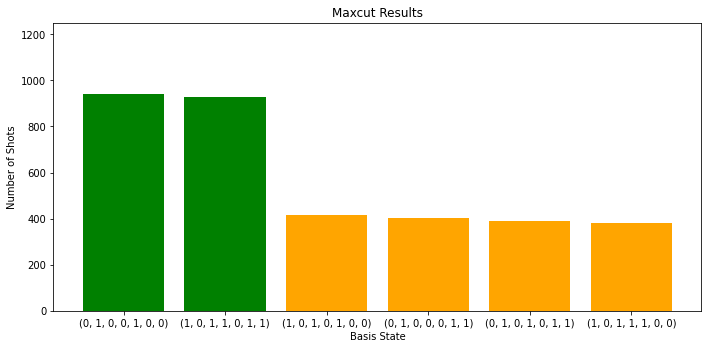

In [51]:
from maxcut_plotting import plot_maxcut_results

plot_maxcut_results(res, 6)

Here the binary strings in the results correspond to the two optimal colourings of our graph.

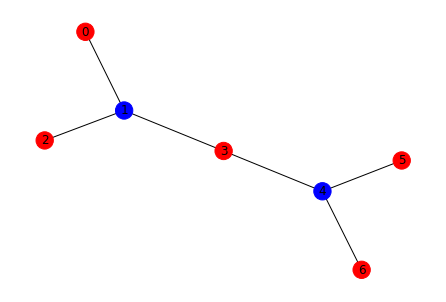

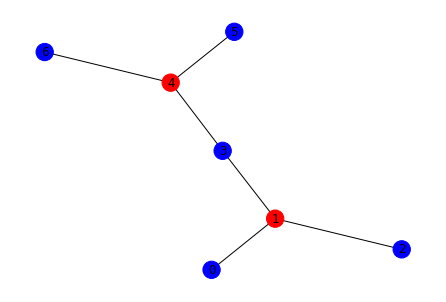

In [52]:
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(G, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['red', 'blue', 'red','red', 'blue', 'red', 'red'])
plt.figure(2)
nx.draw(H, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue'])

plt.show()